# Second Excercises Set - Big data frameworks 2019
## University of Helsinki
## Andres Huertas Suarez 

Run as pyspark from shell in order to automatically load the Spark context
The file objects.py contains the skeletons for the classes used to read the data from the files. 
The data files must be in a folder called data , one level above in the directory structure ( "../data" ) 


In [49]:
sc.version

'2.4.0'

## Excercise 1 -  3 


In [50]:
# Importing data
import pandas as pd
import numpy as np

from timeit import default_timer as timer
import matplotlib.pyplot as plt

import objects

###  Defining a function to read and parse the data

In [39]:
def getRdd2( partitions ):
    
    books = sc.textFile("../data/BX-dataset-fixed/BX-Books.csv"  )
    ratings =  sc.textFile("../data/BX-dataset-fixed/BX-Book-Ratings.csv"  )
    users =  sc.textFile("../data/BX-dataset-fixed/BX-Users.csv"  )
    
    books_rdd = books.map( lambda x: x.replace('"' , '').split(";") ).map( lambda line: objects.Books(line) )
    ratings_rdd = ratings.map(lambda x : x.replace('"' , '').split(";")).map( lambda line:  objects.Ratings(line)  )
    users_rdd = users.map( lambda x: x.replace('"' , '').split(";")).map( lambda line: objects.User(line))
    return books_rdd, ratings_rdd , users_rdd
    


In [104]:
books_rdd , ratings_rdd , users_rdd = getRdd2()

In [105]:
r_u = ratings_rdd.map(  lambda x: ( x.user_id , x  ) ).join( users_rdd.map( lambda x: (x.user_id , x)  )   )

In [106]:
r_u = r_u.map( lambda  x :   (x[1][0].isbn , ( x[1][0], x[1][1] )  ))
books_ratings = books_rdd.map( lambda book :  ( book.isbn , book ) ).join( r_u)

In [107]:
books_ratings.collect()

[('0590257013',
  (<objects.Books at 0x7f7d8f104c88>,
   (<objects.Ratings at 0x7f7d5ca97208>, <objects.User at 0x7f7d1c7506d8>))),
 ('0590257013',
  (<objects.Books at 0x7f7d1c743cf8>,
   (<objects.Ratings at 0x7f7d1c743588>, <objects.User at 0x7f7d1c750c88>))),
 ('0590257013',
  (<objects.Books at 0x7f7d1c743cf8>,
   (<objects.Ratings at 0x7f7d1c6ddb38>, <objects.User at 0x7f7d1c6ddba8>))),
 ('0590257013',
  (<objects.Books at 0x7f7d1c743358>,
   (<objects.Ratings at 0x7f7d5ca020f0>, <objects.User at 0x7f7d1c6ddc88>))),
 ('0688074103',
  (<objects.Books at 0x7f7d1c6ddd30>,
   (<objects.Ratings at 0x7f7d1c6ddd68>, <objects.User at 0x7f7d1c6dddd8>))),
 ('006051969X',
  (<objects.Books at 0x7f7d1c6dde48>,
   (<objects.Ratings at 0x7f7d1c6ddeb8>, <objects.User at 0x7f7d1c6ddf28>))),
 ('0451524640',
  (<objects.Books at 0x7f7d1c6ddf98>,
   (<objects.Ratings at 0x7f7d1c6ddfd0>, <objects.User at 0x7f7d1c6e2080>))),
 ('0451524640',
  (<objects.Books at 0x7f7d1c7439e8>,
   (<objects.Ratings a

In [ ]:
 ('0385336780', ( Books , ( Ratings , User)) ),

In [114]:
def countReviews2( minyear , maxyear , rdd ):
    
    rdd = rdd.filter( lambda x: x[1][1][1].age != -1  )
    filtered = rdd.filter( lambda x : x[1][0].year >= minyear ).filter( lambda x:   x[1][0].year <= maxyear  )
    count = filtered.count()
    return count

In [115]:
countReviews2( 1992 , 1998 , books_ratings )

256882

I also implement other less clean way to read and parse , and an aditionar parameter to pass the number of partitions in order to build a small performance vs partitions graphic.

In [60]:
# isbn, title, author, year, publisher, url1, url2, url3

# books 
# isbn, title, author, year, publisher

#users
# user_id, location, age

#ratings 
# user_id, isbn, rating
def getRdds( partitions  ):
    books = sc.textFile("../data/BX-dataset-fixed/BX-Books.csv" , partitions )
    ratings =  sc.textFile("../data/BX-dataset-fixed/BX-Book-Ratings.csv" , partitions )
    users =  sc.textFile("../data/BX-dataset-fixed/BX-Users.csv" , partitions )
    books_rdd = books.map(lambda line: line.split(";")).map(lambda line: (line[0],  (line[1] , line[2] , line[3] , line[4])  ) ).collect()

    users_rdd = users.map( lambda line: line.split(";")).map( lambda line: (line[0] , (line[1] , line[2])  )).collect()

    ratings_rdd = ratings.map( lambda line: line.split(";")).map( lambda line: (line[0] ,( line[1] , line[2]) )) .collect()

    return books_rdd, users_rdd , ratings_rdd

1 15.74055298300027
2 11.254894399000477
3 10.230366521000178
4 8.697808484000234
5 10.82808808899972
6 9.379528692999884
7 9.299702097999216
8 8.768856821000554
9 9.493069840999851


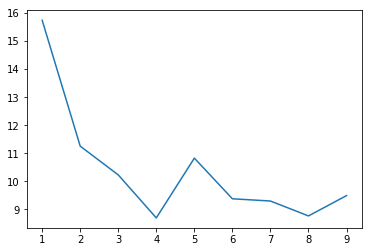

In [62]:
partitions =  list(range(1,10))
times = []
for i in partitions:
    start = timer()
    getRdds( i  )
    end = timer()
    et = end - start
    times.append( et )
    print( i , et ) # Time in seconds, e.g. 5.38091952400282

plt.plot( partitions , times )
plt.show()

In [ ]:
books_rdd.saveAsPickleFile("../data/books")
users_rdd.saveAsPickleFile("../data/users")
ratings_rdd.saveAsPickleFile("../data/ratings")

In [64]:
# read from disk

books_rdd = sc.pickleFile( "../data/books" , minPartitions = 10  )
users_rdd = sc.pickleFile("../data/users" , minPartitions = 10 )
ratings_rdd = sc.pickleFile( "../data/ratings" , minPartitions = 10 )

In [65]:
#ratings_rdd.collect()

In [66]:
user_ratings_rdd = ratings_rdd.join( users_rdd )

In [67]:
user_ratings_rdd2 = user_ratings_rdd.map( lambda x:  ( x[1][0][0] , (  x[0] , x[1][0][1] ,x[1][1][0] , x[1][1][1]   ) )  )#.collect()

In [68]:
user_ratings_rdd2

PythonRDD[918] at RDD at PythonRDD.scala:53

In [69]:
books_ratings = books_rdd.join( user_ratings_rdd2 )

In [70]:
books_ratings.collect()

[('"0471614831"',
  (('"How to Make Money With Your Micro"',
    '"Herman Holtz"',
    '"1989"',
    '"John Wiley &am Sons Inc"'),
   ('"164519"', '"3"', '"atlanta, georgia, usa"', '"NULL"'))),
 ('"0226066789"',
  (('"Forgive and Remember : Managing Medical Failure, 2nd Edition"',
    '"Charles L. Bosk"',
    '"2003"',
    '"Press"'),
   ('"214118"', '"0"', '"rochester, ,"', '"NULL"'))),
 ('"8434890763"',
  (('"Molly Moon Y El Increible Libro De Hipnotismo / Molly Moon\'s Incredible Book of Hypnotism"',
    '"Isabel Gonzalez-Gallarza"',
    '"2003"',
    '"S &am M Books"'),
   ('"39917"', '"8"', '"madrid, madrid, spain"', '"36"'))),
 ('"0330376276"',
  (('"Creed"', '"James Herbert"', '"2001"', '"Pan"'),
   ('"23902"', '"6"', '"london, england, united kingdom"', '"NULL"'))),
 ('"0330376276"',
  (('"Creed"', '"James Herbert"', '"2001"', '"Pan"'),
   ('"180651"', '"0"', '"coventry, england, united kingdom"', '"54"'))),
 ('"0330376276"',
  (('"Creed"', '"James Herbert"', '"2001"', '"Pan"')

In [71]:
def countReviews( minyear , maxyear , rdd ):
    
    filtered = rdd.filter( lambda x : int(x[1][0][2].replace('"', '')  ) >= minyear ).filter( lambda x: int(x[1][0][2].replace('"', '') ) <= maxyear  )
    count = filtered.count()
    return count
    

In [72]:
countReviews( 1992 , 1998  , books_ratings ) 

356317

# Excercise 4 


Here I will use the data loaded in the less clear way. but it work. the problem is that we have to keep the track ( manually ) of in which positions is the data stored. But it work. Must highlight that there must be something wrong with the data given that the top authors retrieved by the functions, are authors that have one review and something that must be a wrong age

In [73]:

def topNAvg( rdd , top = 20 , asc = False ):
    
    rdd = rdd.map( lambda x : ( x[1][0][1] ,  int( x[1][1][3].replace('"NULL' , "-1").replace('"' , "")  )    )  )
    rdd = rdd.filter ( lambda x : x[1] != -1 )
    
    counts =  rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).map(lambda v:( v[0], (float(v[1][0])/v[1][1])) )
    sorted_rdd = counts.sortBy( lambda x: x[1], asc ).take(20) #collect()[:top]
    return  sorted_rdd #sorted_rdd #counts
    


In [74]:
topNAvg( books_ratings )

[('"Chris C. Fisher"', 239.0),
 ('"Robin Bovey"', 239.0),
 ('"Walter Gretzky"', 239.0),
 ('"Carlton Fredericks"', 228.0),
 ('"Charles Gill"', 228.0),
 ('"V. Wayne Klemin"', 228.0),
 ('"Alison Bell"', 228.0),
 ('"Old Farmer\'s Almanac"', 228.0),
 ('"Ronald Comer"', 228.0),
 ('"Ed Smith"', 228.0),
 ('"Robert H. Ramsey"', 228.0),
 ('"James W. Kalat"', 228.0),
 ('"Neil R Carlson"', 228.0),
 ('"Mark Pfetzer"', 219.0),
 ('"Rink Van Der Velde"', 204.0),
 ('"Christian R. Hirsch"', 204.0),
 ('"Alan Neibauer"', 204.0),
 ('"Don Gerrard"', 204.0),
 ('"Roland Anthony Oliver"', 201.0),
 ('"Victoria Roberts"', 201.0)]

In [75]:
# 239?? lets check the books for this author
books_ratings.filter( lambda x: x[1][0][1]  == '"Robin Bovey"'  ).collect()

# Only one, reviewed by an user, witch age 239.... 

[('"0919433820"',
  (('"Birds of Calgary (Canadian City Bird Guides)"',
    '"Robin Bovey"',
    '"1990"',
    '"Lone Pine Publishing"'),
   ('"8782"', '"10"', '"calgary, alberta, canada"', '"239"')))]

## Excersice 5

In [76]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType

In [77]:
#user_id, location, age
user_schema = StructType([
    StructField("user_id", StringType()),
    StructField("location", StringType()),
    StructField("age", IntegerType()),
])
# books 
# isbn, title, author, year, publisher
book_schema = StructType([
    StructField("isbn", StringType()),
    StructField("title", StringType()),
    StructField("author", StringType()),
    StructField("year", IntegerType()),
    StructField("publisher", StringType()),
])
#ratings 
# user_id, isbn, rating
rating_schema = StructType([
    StructField("user_id", StringType()),
    StructField("isbn", StringType()),
    StructField("rating", IntegerType()),
])

In [123]:
users_df = spark.read.csv('../data/BX-dataset-fixed/BX-Users.csv', header=True, schema=user_schema , sep = ";")
books_df = spark.read.csv('../data/BX-dataset-fixed/BX-Books.csv', header=True, schema=book_schema , sep = ";")
ratings_df = spark.read.csv('../data/BX-dataset-fixed/BX-Book-Ratings.csv', header=True, schema=rating_schema , sep = ";")

In [125]:
#users_df = users_df.filter(  users_df.age != None )
users_df = users_df.na.drop(subset=["age"])

In [126]:
users_df.collect()

[Row(user_id='2', location='stockton, california, usa', age=18),
 Row(user_id='4', location='porto, v.n.gaia, portugal', age=17),
 Row(user_id='6', location='santa monica, california, usa', age=61),
 Row(user_id='10', location='albacete, wisconsin, spain', age=26),
 Row(user_id='11', location='melbourne, victoria, australia', age=14),
 Row(user_id='13', location='barcelona, barcelona, spain', age=26),
 Row(user_id='18', location='rio de janeiro, rio de janeiro, brazil', age=25),
 Row(user_id='19', location='weston, ,', age=14),
 Row(user_id='20', location='langhorne, pennsylvania, usa', age=19),
 Row(user_id='21', location='ferrol / spain, alabama, spain', age=46),
 Row(user_id='24', location='cologne, nrw, germany', age=19),
 Row(user_id='25', location='oakland, california, usa', age=55),
 Row(user_id='27', location='chicago, illinois, usa', age=32),
 Row(user_id='28', location='freiburg, baden-wuerttemberg, germany', age=24),
 Row(user_id='29', location='cuernavaca, alabama, mexico',

In [127]:
#users_ratings.join()
users_ratings = users_df.join(   ratings_df , users_df.user_id == ratings_df.user_id )

In [128]:
users_ratings.collect()

[Row(user_id='100140', location='oxford, england, united kingdom', age=36, user_id='100140', isbn='0099278359', rating=2),
 Row(user_id='100140', location='oxford, england, united kingdom', age=36, user_id='100140', isbn='0099456761', rating=8),
 Row(user_id='100140', location='oxford, england, united kingdom', age=36, user_id='100140', isbn='0099727412', rating=7),
 Row(user_id='100140', location='oxford, england, united kingdom', age=36, user_id='100140', isbn='0747265410', rating=4),
 Row(user_id='100140', location='oxford, england, united kingdom', age=36, user_id='100140', isbn='0747557861', rating=6),
 Row(user_id='100227', location='tehran, tehran, iran', age=36, user_id='100227', isbn='0006514480', rating=8),
 Row(user_id='100227', location='tehran, tehran, iran', age=36, user_id='100227', isbn='0060090367', rating=0),
 Row(user_id='100227', location='tehran, tehran, iran', age=36, user_id='100227', isbn='0060549270', rating=0),
 Row(user_id='100227', location='tehran, tehran, 

In [129]:
users_books = books_df.join( users_ratings , users_ratings.isbn == books_df.isbn , how ='left'  )

In [130]:
#users_books.collect()

In [131]:
def countReviews3( df , minyear = 1992 , maxyear = 1998):
    
    df = df.filter( df.year >= minyear ).filter( df.year <=  maxyear)
    counts = df.count()
    return counts
    

In [132]:
countReviews3( users_books )

271055

# Excercise 6


HDFS
Stands for Hadoop Distributed File System. Is the default file system used by the Hadopp framework in order work efficiently  in distribuited systems with large files. 

Spark Tachyon
Now known as Alluxio, is an open source framework that looks for virtualization of data storage and creates a "virtual data lake" that allows integration of data from different sources under the same namespace. Alluxio will work "above" Spark, acting as a "gate" in order to access the distributed data in ( but not restricted to ) Spark. 


Remote direct memory access (RDMA)

Is a method that allows different computers to share memory in a direct way, where one computer can reach the memory from other directly without involving calulations in the CPUs or partial copies in caches. This methods has become an important piece of technologie for HPC application an data centers. 


Spark DataFrames


DataFrames Spark are an abstracction over the data that allow and easy an undestandable interface, since it reminds the pandas DataFrames that at the same time resamble SQL or Excelt tables. In this way, operations like join, merge and the use of APIs that are close to the pandas syntax becomes more easy for developers